In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime, pytz

from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.metrics import RootMeanSquaredError

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

## Hyperparameter

In [2]:
# Google Spreadsheet ID
SHEET_ID = '1JDNv_mArl-GPIpxuWS5GxgVEwvjXocS1MrXGc6TYs8M'
SHEET_NAME = 'EUR/IDR' # USD/IDR, EUR/IDR, SGD/IDR

SEQ_LEN = 21 # 6, 11, 21
SPLIT = 0.90 # 0.80, 0.90
LSTM_Layer = 2 # 1, 2, 3
WINDOW_SIZE = SEQ_LEN - 1

In [3]:
url = f'https://docs.google.com/spreadsheets/d/{SHEET_ID}/gviz/tq?tqx=out:csv&sheet={SHEET_NAME}'
data = pd.read_csv(url)

# Convert Date columns to datetime format
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y %H:%M:%S')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1977 entries, 0 to 1976
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1977 non-null   datetime64[ns]
 1   Close   1977 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 31.0 KB


## Preprocessing

In [4]:
def replace_outliers(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data[data < lower_bound] = lower_bound
    data[data > upper_bound] = upper_bound
    return data

data['Close'] = replace_outliers(data['Close'])

/tmp/ipykernel_27/2274720815.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[data < lower_bound] = lower_bound
/tmp/ipykernel_27/2274720815.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[data > upper_bound] = upper_bound


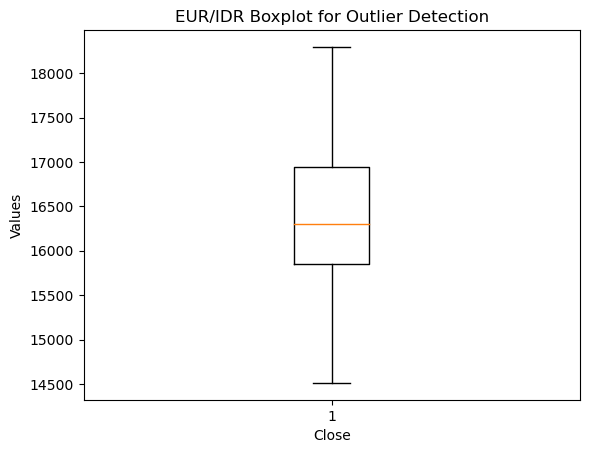

In [5]:
# Boxplot for outlier detection
plt.boxplot(data['Close'])
plt.title(f"{SHEET_NAME} Boxplot for Outlier Detection")
plt.xlabel("Close")
plt.ylabel("Values")
plt.show()

In [6]:
scaler = MinMaxScaler()
close_price = data.Close.values.reshape(-1, 1)
scaled_close = scaler.fit_transform(close_price)
scaled_close.shape

(1977, 1)

In [7]:
def to_sequences(data, seq_len):
    d = []
    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])
    return np.array(d)

def preprocess(data_raw, seq_len, train_split):
    data = to_sequences(data_raw, seq_len)
    num_train = int(train_split * data.shape[0])
    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]
    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = SPLIT)

## Genetic Algorithm

In [8]:
def decimal_to_binary(chromosome: list):
    binary_string = ''.join([bin(x)[2:].zfill(8) for x in chromosome])
    return binary_string

def binary_to_decimal(binary_string: str):
    decimal_array = [int(binary, 2) for binary in [binary_string[i:i+8] for i in range(0, len(binary_string), 8)]]
    return decimal_array

In [9]:
# Genetic Algorithm
def genetic_algorithm(generations, mutation_rate):
    print(f"Inizialized Population...")
    population = np.random.randint(1, high=251, size=(10, 3))
    fitness_scores = np.array([fitness_function(chromosome) for chromosome in population])
    max_fitness_each_gen = []
    
    for generation in range(generations):
        print(f"Generation - {generation + 1}")
        max_fitness_each_gen.append(np.max(fitness_scores))
        
        chromosome_1 = selection(population, fitness_scores)
        chromosome_2 = selection(population, fitness_scores)
        
        if generation % mutation_rate == 0:
            chromosome_1 = mutate(chromosome_1)
            chromosome_2 = mutate(chromosome_2)
        else:
            chromosome_1, chromosome_2 = crossover(chromosome_1, chromosome_2)

        fitness_score_1 = fitness_function(chromosome_1)
        fitness_score_2 = fitness_function(chromosome_2)
        
        worst_index = np.argmin(fitness_scores)
        worst_fitness = fitness_scores[worst_index]

        if fitness_score_1 > worst_fitness:
            population[worst_index] = chromosome_1
            fitness_scores[worst_index] = fitness_score_1
            worst_index = np.argmin(fitness_scores)
            worst_fitness = fitness_scores[worst_index]

        if fitness_score_2 > worst_fitness:
            population[worst_index] = chromosome_2
            fitness_scores[worst_index] = fitness_score_2
        
        # Release some memory
        del chromosome_1, chromosome_2
        del fitness_score_1, fitness_score_2
        del worst_index, worst_fitness
            
    best_chromosome = population[np.argmax(fitness_scores)]
    best_fitness = np.max(fitness_scores)
    
    return best_chromosome, best_fitness, max_fitness_each_gen

# Selection (Tournament selection)
def selection(population, fitness_scores, tournament_size=3):
    indices = np.random.randint(len(population), size=tournament_size)
    tournament = population[indices]
    tournament_fitness = fitness_scores[indices]
    return tournament[np.argmax(tournament_fitness)]

# Crossover (Single-point crossover)
def crossover(parent_1: list, parent_2: list):
    parent_1 = decimal_to_binary(parent_1)
    parent_2 = decimal_to_binary(parent_2)
    
    crossover_point = np.random.randint(1, len(parent_1))
    offspring_1 = parent_1[:crossover_point] + parent_2[crossover_point:]
    offspring_2 = parent_2[:crossover_point] + parent_1[crossover_point:]
    
    offspring_1 = binary_to_decimal(offspring_1)
    offspring_2 = binary_to_decimal(offspring_2)
    return offspring_1, offspring_2

# Mutation (Swap Mutation)
def mutate(chromosome: list):
    chromosome = decimal_to_binary(chromosome)
    
    chromosome_list = list(chromosome)
    i = np.random.randint(len(chromosome_list), size=2)
    chromosome_list[i[0]], chromosome_list[i[1]] = chromosome_list[i[1]], chromosome_list[i[0]]
    
    chromosome_list = ''.join(chromosome_list)
    chromosome = binary_to_decimal(chromosome_list)
    return chromosome

# Fitness Function
def fitness_function(chromosome: list):
    lstm_units = [int(chromosome[i]) or default for i, default in enumerate([128, 64, 32])]

    # Build the LSTM model
    tf.keras.backend.clear_session()
    model = Sequential()
    for i, units in enumerate(lstm_units[:LSTM_Layer]):
        model.add(LSTM(units, return_sequences=(i < LSTM_Layer - 1), input_shape=(WINDOW_SIZE, 1)))
    model.add(Dense(1))
    
    # Compile and train the model
    model.compile(loss='mean_squared_error',
                  optimizer='adam')
    model.fit(X_train, y_train,
              epochs=10,
              batch_size=32,
              verbose=0,
              validation_split=0.1)

    # Evaluate the model
    loss = model.evaluate(X_test, y_test)

    # Return the negative value of the loss as the fitness score
    return -loss

In [10]:
import typing
from datetime import datetime

def timer(start_time: datetime = None) -> "typing.Union[datetime.datetime, str]":
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        return "%i hours %i minutes and %s seconds." % (
            thour,
            tmin,
            round(tsec, 2),
        )

In [11]:
# Do not increase this value
generations = 50
mutation_rate = 5

time = timer(None)
best_chromosome, best_fitness, max_fitness_each_gen = genetic_algorithm(generations, mutation_rate)
time = timer(time)

Inizialized Population...
7/7 [==============================] - 0s 3ms/step - loss: 0.0014
Generation - 1
7/7 [==============================] - 0s 4ms/step - loss: 8.3150e-04
Generation - 2
7/7 [==============================] - 0s 3ms/step - loss: 0.0010
Generation - 3
7/7 [==============================] - 0s 4ms/step - loss: 0.0011
Generation - 4
7/7 [==============================] - 0s 4ms/step - loss: 7.7257e-04
Generation - 5
7/7 [==============================] - 0s 4ms/step - loss: 0.0011
Generation - 6
7/7 [==============================] - 0s 3ms/step - loss: 7.8018e-04
Generation - 7
7/7 [==============================] - 0s 4ms/step - loss: 9.3140e-04
Generation - 8
7/7 [==============================] - 0s 3ms/step - loss: 0.0011
Generation - 9
7/7 [==============================] - 0s 4ms/step - loss: 7.8320e-04
Generation - 10
7/7 [==============================] - 0s 3ms/step - loss: 7.8475e-04
Generation - 11
7/7 [==============================] - 0s 4ms/step - loss

In [12]:
print("Best Chromosome:", best_chromosome)
print("Best Fitness:", best_fitness)
print("Time Taken:", time)

Best Chromosome: [156 115 209]
Best Fitness: -0.0007600974640809
Time Taken: 0 hours 14 minutes and 38.84 seconds.


In [13]:
max_fitness_each_gen

[-0.0007864320650696754,
 -0.0007864320650696754,
 -0.0007864320650696754,
 -0.0007864320650696754,
 -0.0007725728210061789,
 -0.0007725728210061789,
 -0.0007725728210061789,
 -0.0007725728210061789,
 -0.0007725728210061789,
 -0.0007725728210061789,
 -0.0007725728210061789,
 -0.0007725728210061789,
 -0.0007725728210061789,
 -0.0007725728210061789,
 -0.0007725728210061789,
 -0.0007725728210061789,
 -0.0007725728210061789,
 -0.0007725728210061789,
 -0.0007635888177901506,
 -0.0007635888177901506,
 -0.0007635888177901506,
 -0.0007635888177901506,
 -0.0007635888177901506,
 -0.0007635888177901506,
 -0.0007600974640809,
 -0.0007600974640809,
 -0.0007600974640809,
 -0.0007600974640809,
 -0.0007600974640809,
 -0.0007600974640809,
 -0.0007600974640809,
 -0.0007600974640809,
 -0.0007600974640809,
 -0.0007600974640809,
 -0.0007600974640809,
 -0.0007600974640809,
 -0.0007600974640809,
 -0.0007600974640809,
 -0.0007600974640809,
 -0.0007600974640809,
 -0.0007600974640809,
 -0.0007600974640809,
 -0.

## Re-Training Model with Best Parameter

In [14]:
model = Sequential()
for i, units in enumerate(best_chromosome[:LSTM_Layer]):
    model.add(LSTM(units, return_sequences=(i < LSTM_Layer - 1), input_shape=(WINDOW_SIZE, 1)))
model.add(Dense(1))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 20, 156)           98592     
                                                                 
 lstm_3 (LSTM)               (None, 115)               125120    
                                                                 
 dense_1 (Dense)             (None, 1)                 116       
                                                                 
Total params: 223,828
Trainable params: 223,828
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.compile(loss='mean_squared_error',
              metrics=['mae', RootMeanSquaredError()],
              optimizer='adam')

history = model.fit(X_train,
                    y_train,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.1)

Epoch 1/50
50/50 [==============================] - 5s 22ms/step - loss: 0.0163 - mae: 0.0823 - root_mean_squared_error: 0.1278 - val_loss: 0.0038 - val_mae: 0.0504 - val_root_mean_squared_error: 0.0618
Epoch 2/50
50/50 [==============================] - 0s 7ms/step - loss: 0.0025 - mae: 0.0351 - root_mean_squared_error: 0.0500 - val_loss: 0.0025 - val_mae: 0.0395 - val_root_mean_squared_error: 0.0503
Epoch 3/50
50/50 [==============================] - 0s 7ms/step - loss: 0.0023 - mae: 0.0330 - root_mean_squared_error: 0.0476 - val_loss: 0.0024 - val_mae: 0.0385 - val_root_mean_squared_error: 0.0488
Epoch 4/50
50/50 [==============================] - 0s 8ms/step - loss: 0.0020 - mae: 0.0311 - root_mean_squared_error: 0.0447 - val_loss: 0.0022 - val_mae: 0.0370 - val_root_mean_squared_error: 0.0471
Epoch 5/50
50/50 [==============================] - 0s 7ms/step - loss: 0.0022 - mae: 0.0339 - root_mean_squared_error: 0.0469 - val_loss: 0.0022 - val_mae: 0.0374 - val_root_mean_squared_err

In [16]:
model.evaluate(X_test, y_test)

7/7 [==============================] - 0s 4ms/step - loss: 5.7498e-04 - mae: 0.0170 - root_mean_squared_error: 0.0240


[0.0005749837146140635, 0.017001524567604065, 0.023978818207979202]

## Model Evaluation

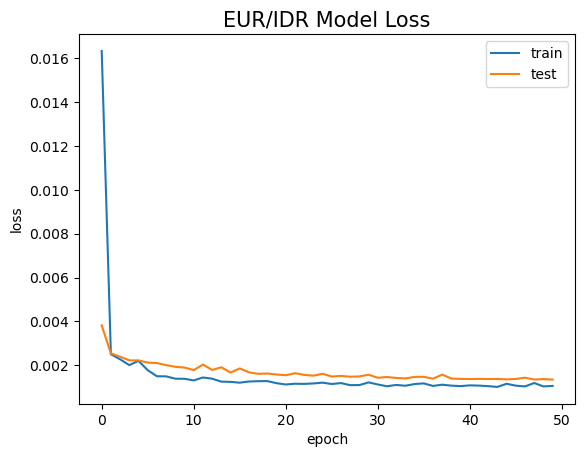

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'{SHEET_NAME} Model Loss', fontsize=15)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

In [18]:
y_hat = model.predict(X_test)
y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)

7/7 [==============================] - 1s 3ms/step


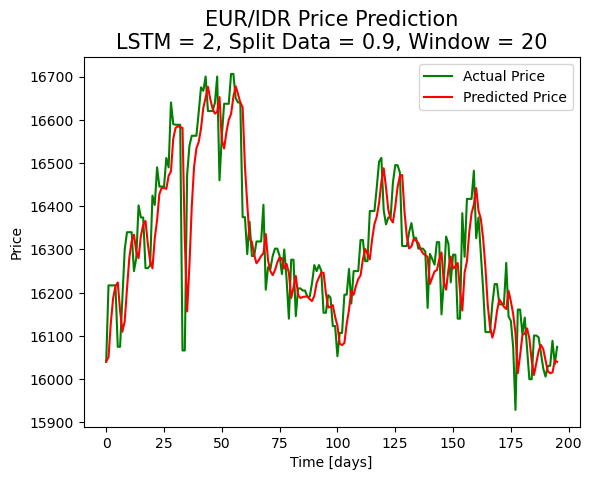

In [19]:
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title(f'{SHEET_NAME} Price Prediction\nLSTM = {LSTM_Layer}, Split Data = {SPLIT}, Window = {WINDOW_SIZE}', fontsize=15)
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show()

In [20]:
def matrices(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mse)
    print("Mean Absolute Error for prediction :", mae)
    print("Mean Squared Error for prediction :", mse)
    print("Root Mean Squared Error for prediction :", rmse)
    return mae, mse, rmse

print(f"LSTM = {LSTM_Layer}, Split Data = {SPLIT}, Window = {WINDOW_SIZE}")
print("\n----------------- Normalized Error -----------------")
mae, mse, rmse = matrices(y_test, y_hat)
print("\n----------------- Actual Error -----------------")
mae_inverse, mse_inverse, rmse_inverse = matrices(y_test_inverse, y_hat_inverse)

LSTM = 2, Split Data = 0.9, Window = 20

----------------- Normalized Error -----------------
Mean Absolute Error for prediction : 0.017001522123883096
Mean Squared Error for prediction : 0.00057498366695028
Root Mean Squared Error for prediction : 0.023978817046515867

----------------- Actual Error -----------------
Mean Absolute Error for prediction : 64.33377491230887
Mean Squared Error for prediction : 8232.993758587942
Root Mean Squared Error for prediction : 90.7358460509844
